In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import seaborn as sn
import statsmodels.api as sm
from pylab import rcParams

In [36]:
#Read the csv file
df=pd.read_csv('merged_data.csv',parse_dates=['mkt_datetime'])

In [37]:
df=df[:23376]

In [38]:
df.head()

,mkt_datetime,int_nuc_sch,int_gas_sch,int_hyd_sch,int_win_sch,imp_mic_sch,imp_new_sch,imp_que_sch,ont_avg_dem,exp_mic_sch,exp_new_sch,exp_que_sch,ont_ene
0,2020-01-01 00:00:00,11554,216,2857,2113,0,0,9,13305,-800,-1285,-1273,0.0
1,2020-01-01 01:00:00,11554,216,2834,1595,0,0,9,12870,-800,-1285,-1273,0.0
2,2020-01-01 02:00:00,11554,216,2834,1506,0,0,9,12512,-800,-1390,-1273,0.0
3,2020-01-01 03:00:00,11554,216,2835,1592,0,0,9,12370,-800,-1443,-1273,0.0
4,2020-01-01 04:00:00,11554,216,2911,1479,0,0,9,12469,-800,-1440,-1273,0.0


In [39]:
#Variables for training
cols = ['mkt_datetime','ont_ene']
uni_df=df[cols]
uni_df.set_index('mkt_datetime', inplace=True)

In [40]:
uni_df.head()

,ont_ene
mkt_datetime,
2020-01-01 00:00:00,0.0
2020-01-01 01:00:00,0.0
2020-01-01 02:00:00,0.0
2020-01-01 03:00:00,0.0
2020-01-01 04:00:00,0.0


In [41]:
y = uni_df['ont_ene'].resample('MS').mean()

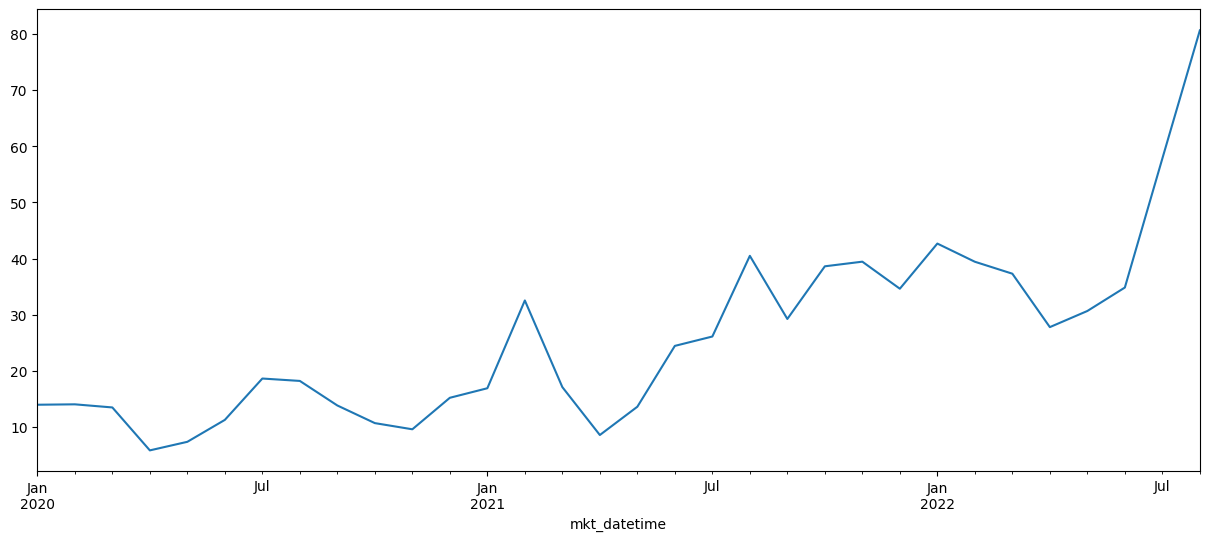

In [42]:
y.plot(figsize=(15, 6))
plt.show()

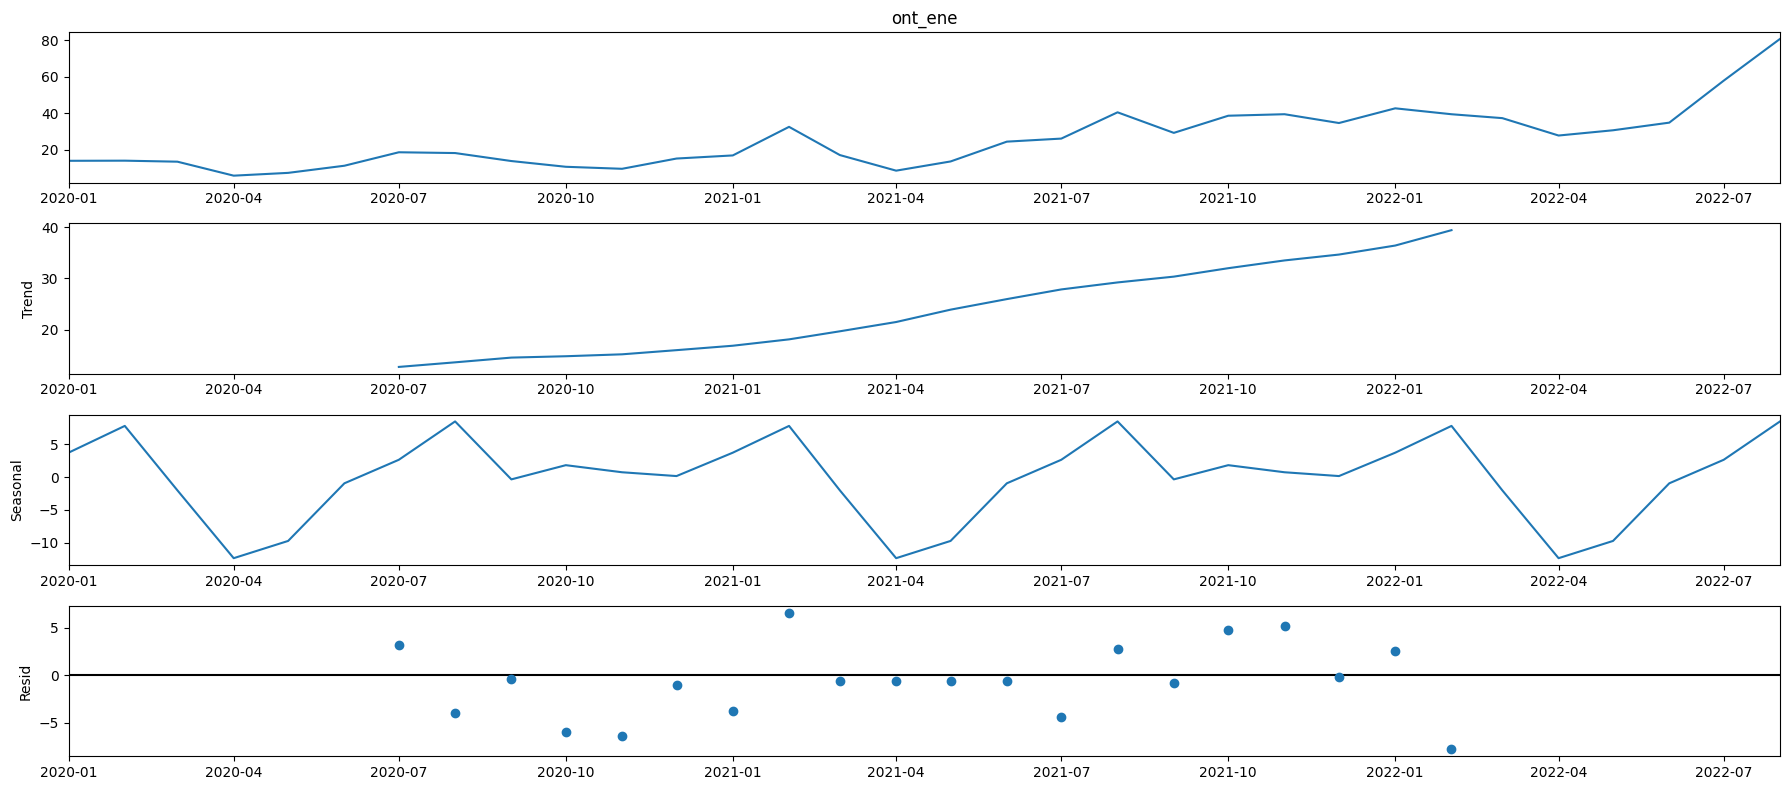

In [43]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [44]:
# normalize the data_set 
sc = MinMaxScaler(feature_range = (0, 1))
uni_df = sc.fit_transform(uni_df)

In [45]:
# split into train and test sets
train_size = int(len(uni_df) * 0.70)
test_size = len(uni_df) - train_size
train, test = uni_df[0:train_size,:], uni_df[train_size:len(uni_df),:]

In [46]:
train.shape

(16363, 1)

In [47]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [54]:
# reshape into X=t and Y=t+1
look_back =96
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [49]:
Y_train.shape

(16266,)

In [50]:
# regressor = Sequential()

# regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# regressor.add(Dropout(0.1))

# regressor.add(LSTM(units = 60, return_sequences = True))
# regressor.add(Dropout(0.1))

# regressor.add(LSTM(units = 60))
# regressor.add(Dropout(0.1))

# regressor.add(Dense(units = 1))

# regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
# history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

In [51]:
# regressor.save('lstm_uni_model')

In [52]:
regressor = tf.keras.models.load_model('lstm_uni_model')

2022-09-20 17:02:33.367877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 17:02:33.371015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 17:02:33.371229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-20 17:02:33.371391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-20 17:02:33.371544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [55]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

217/217 [==============================] - 11s 49ms/step


In [63]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

In [68]:
train_predict.shape

(16266, 1)

Train Mean Absolute Error: 5.689835870170929
Train Root Mean Squared Error: 22.305203357442977
Test Mean Absolute Error: 9.987663825915083
Test Root Mean Squared Error: 23.798226089527134


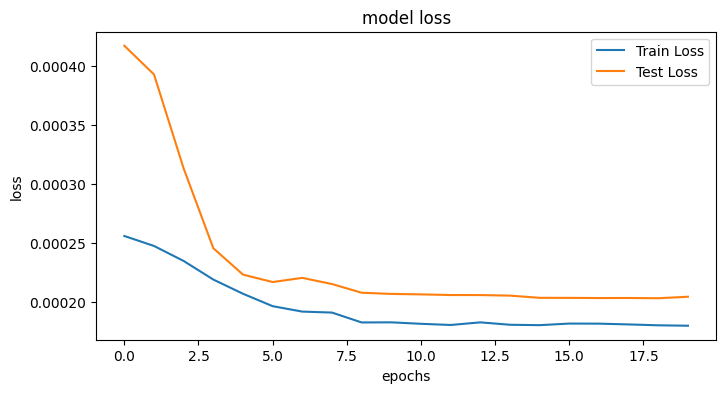

In [18]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

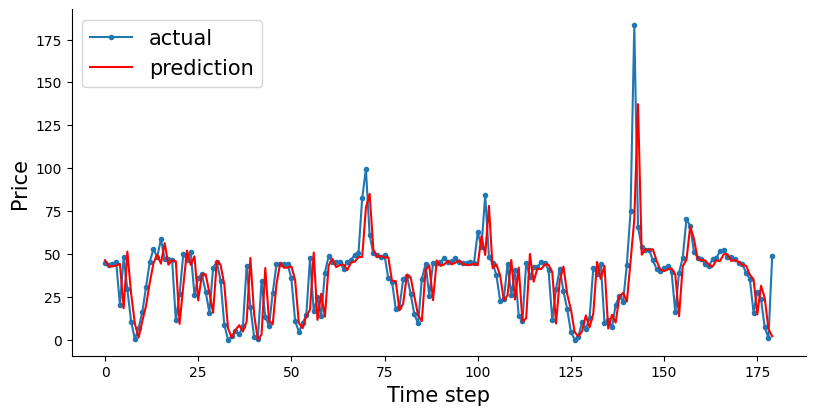

In [19]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sn.despine(top=True)
# plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [29]:
sc.inverse_transform(X_train[0]).reshape(-1)

array([ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00, -4.000e-02,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  2.920e+00,  1.800e+00,  0.000e+00,
        0.000e+00,  1.390e+00,  5.440e+00,  1.720e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00, -4.000e-02,
       -1.200e-01, -2.860e+00, -3.000e+00, -1.000e-01, -3.000e-02,
        0.000e+00,  1.730e+00,  0.000e+00,  3.900e-01,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  1.600e+00,  2.670e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00, -4.000e-02, -1.000e-02,
        0.000e+00, -4.000e-02,  0.000e+00,  4.300e+00,  3.180e+00,
        1.017e+01,  1.437e+01,  2.213e+01,  8.616e+01,  3.077e+01,
        2.143e+01,  1.976e+01,  2.142e+01,  1.951e+01,  1.966e+01,
        2.018e+01,  1.876e+01,  2.015e+01,  1.973e+01,  1.704e+01,
        1.573e+01,  1.371e+01,  1.693e+01,  1.517e+01,  1.436e